# BIG PROJECT HOME ASSIGNEMNT – 03
# LAZY FORMAL CONCEPT ANALYSIS (FCA)

### Vivaka Nand
### December 2024


### Import necessary libraries

In [34]:
# Import necessary libraries for data processing, visualization, and machine learning
import pandas as pd  
import numpy as np   
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.model_selection import train_test_split  
from typing import List, Any
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')

In [35]:
df = pd.read_csv('Heart_binarized.csv') 
df.head()

,age_le_28.0,age_ge_28.0,age_le_40,age_ge_40,age_le_60,age_ge_60,age_le_77.0,age_ge_77.0,sex_male,sex_female,...,slope_upsloping,slope_downsloping,ca_0,ca_1,ca_2,ca_3,thal_normal,thal_fixed_defect,thal_reversible_defect,num
0,0,1,0,1,0,1,1,0,1,0,...,0,1,1,0,0,0,0,1,0,0
1,0,1,0,1,0,1,1,0,1,0,...,0,0,0,0,0,1,1,0,0,1
2,0,1,0,1,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,1,1
3,0,1,1,0,1,0,1,0,1,0,...,0,1,1,0,0,0,1,0,0,0
4,0,1,0,1,1,0,1,0,0,1,...,1,0,1,0,0,0,1,0,0,0


### Separate the features and target variables

In [36]:
# Separate the features (X) and target (y) variables for model training
X = df.drop(columns='num')  # Drop the target variable 'num' from the features
y = df['num']  # Target variable 'num' (presence of heart disease)

### Split Data into Train Test datasets

In [37]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape)  # Display the shape of the training feature set
print(y_train.shape)  # Display the shape of the training target set
print(X_test.shape)   # Display the shape of the test feature set
print(y_test.shape)   # Display the shape of the test target set

(735, 69)
(735,)
(184, 69)
(184,)


### Lazy FCA Baseline Model

In [38]:
# Define a Lazy FCA Classifier class
class LazyFCAClassifier:
    def __init__(self):
        # Initialize the classifier, storing training data for later use
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        """
        Store training data for use during classification.
        :param X_train: DataFrame containing training features.
        :param y_train: Series containing training labels (binary classification).
        """
        self.X_train = X_train
        self.y_train = y_train

    def _get_intersection(self, sample: pd.Series, other_sample: pd.Series) -> pd.Series:
        """
        Compute the intersection (bitwise AND) of two binary samples.
        :param sample: Test sample.
        :param other_sample: A sample from the training set.
        :return: A binary series indicating the intersection.
        """
        return sample & other_sample

    def classify_sample(self, sample: pd.Series) -> Any:
        """
        Classify a single test sample based on Lazy FCA classification rules.
        :param sample: A sample from the test set.
        :return: Predicted class (0 or 1) for the sample.
        """
        # Separate training data into positive and negative classes
        X_pos = self.X_train[self.y_train == 1]
        X_neg = self.X_train[self.y_train == 0]

        # Initialize counters for positive and negative classifiers
        pos_count = 0
        neg_count = 0

        # Define rules to identify positive classifiers
        def is_positive_classifier(intersection):
            # True if the intersection is unique to positive samples
            return ((X_pos | ~intersection) == True).all(axis=1).sum() > 1 and \
                   ((X_neg | ~intersection) == True).all(axis=1).sum() == 0

        # Define rules to identify negative classifiers
        def is_negative_classifier(intersection):
            # True if the intersection is unique to negative samples
            return ((X_neg | ~intersection) == True).all(axis=1).sum() > 1 and \
                   ((X_pos | ~intersection) == True).all(axis=1).sum() == 0

        # Check for positive classifiers by comparing with positive training samples
        for _, pos_sample in X_pos.iterrows():
            # Compute the intersection between the test sample and positive samples
            intersection = self._get_intersection(sample, pos_sample)
            if is_positive_classifier(intersection):
                # Increment positive classifier count if condition is satisfied
                pos_count += 1

        # Check for negative classifiers by comparing with negative training samples
        for _, neg_sample in X_neg.iterrows():
            # Compute the intersection between the test sample and negative samples
            intersection = self._get_intersection(sample, neg_sample)
            if is_negative_classifier(intersection):
                # Increment negative classifier count if condition is satisfied
                neg_count += 1

        # Decision: Assign class based on the number of classifiers
        if pos_count > neg_count:
            #print(f"sample {sample.name} is classified as 1, {pos_count=}, {neg_count=}")
            return 1  # Predict positive class
        elif neg_count > pos_count:
            #print(f"sample {sample.name} is classified as 0, {pos_count=}, {neg_count=}")
            return 0  # Predict negative class
        else:
            # Tie-breaking rule: Default to class 1 if there's a tie
            #print(f"sample {sample.name} is classified as 1, default, {pos_count=}, {neg_count=}")
            return 1

    def predict(self, X_test: pd.DataFrame) -> List[Any]:
        """
        Predict classes for all samples in the test set.
        :param X_test: DataFrame containing test samples.
        :return: List of predicted classes for each sample.
        """
        # Iterate over test samples and classify each one
        predictions = [self.classify_sample(row) for _, row in X_test.iterrows()]
        return predictions


### Lazy FCA Classifier using  Jaccard similarity (intersection/union) Threshold

In [39]:
class LazyClassifierFCA_2:
    def __init__(self):
        self.X_train = None
        self.y_train = None
        self.train_positive = None
        self.train_negative = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        """
        Fit the classifier with training data.
        """
        self.X_train = X_train
        self.y_train = y_train
        self.train_positive = X_train[y_train == 1]
        self.train_negative = X_train[y_train == 0]
        print(f"Training data split: {self.train_positive.shape[0]} positive samples, {self.train_negative.shape[0]} negative samples.")

    def classify_sample(self, sample: np.ndarray, threshold: float = 0.5) -> int:
        """
        Classify a single sample using Lazy FCA with optimized NumPy operations.
        """
        # Use element-wise logical operations to compute intersections
        sample = sample.astype(bool)

        # Calculate intersection sizes
        positive_intersections = np.logical_and(self.train_positive, sample)
        negative_intersections = np.logical_and(self.train_negative, sample)

        positive_sizes = positive_intersections.sum(axis=1)
        negative_sizes = negative_intersections.sum(axis=1)

        # Debug: Print intersection sizes
        #print(f"Sample: {sample}")
        #print(f"Positive intersections: {positive_sizes}")
        #print(f"Negative intersections: {negative_sizes}")

        # Calculate union sizes
        positive_unions = np.logical_or(self.train_positive, sample).sum(axis=1)
        negative_unions = np.logical_or(self.train_negative, sample).sum(axis=1)

        # Debug: Print union sizes
        #print(f"Positive unions: {positive_unions}")
        #print(f"Negative unions: {negative_unions}")

        # Compute Jaccard similarity (intersection/union)
        positive_scores = positive_sizes / positive_unions
        negative_scores = negative_sizes / negative_unions

        # Debug: Print similarity scores
        #print(f"Positive Jaccard scores: {positive_scores}")
        #print(f"Negative Jaccard scores: {negative_scores}")

        # Count classifiers meeting the threshold
        positive_classifiers = np.sum(positive_scores >= threshold)
        negative_classifiers = np.sum(negative_scores >= threshold)

        # Debug: Print classifier counts
        #print(f"Positive classifiers: {positive_classifiers}, Negative classifiers: {negative_classifiers}")

        # Determine class
        if positive_classifiers > negative_classifiers:
            #print(f"Sample classified as 1 (positive).")
            return 1
        elif negative_classifiers > positive_classifiers:
            #print(f"Sample classified as 0 (negative).")
            return 0
        else:
            #print(f"Sample classified as 1 (default due to tie).")
            return 1  # Default decision

    def predict(self, X_test: pd.DataFrame, threshold: float = 0.5) -> np.ndarray:
        """
        Predict the class of each sample in the test set.
        """
        X_test = X_test.reindex(columns=self.X_train.columns, fill_value=0)  # Align columns
        X_test_np = X_test.to_numpy(dtype=bool)

        # Debug: Start prediction
        #print(f"Predicting classes for {len(X_test)} samples.")

        # Use list comprehension for classification
        predictions = np.array(
            [self.classify_sample(sample, threshold=threshold) for sample in X_test_np]
        )

        return predictions

### Evaluation Metrics

In [40]:
# Function to calculate all quality metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Metrics calculations
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fdr = fp / (fp + tp) if (fp + tp) > 0 else 0
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {
        "True Positive": tp,
        "True Negative": tn,
        "False Positive": fp,
        "False Negative": fn,
        "Specificity": specificity,
        "NPV": npv,
        "FPR": fpr,
        "FDR": fdr,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    }

In [41]:
# Function to evaluate models
def evaluate_models(models, X_train, y_train, X_test, y_test):
    metrics_list = []  # List to store metrics for each model

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")  # Debugging output

        # Measure training time
        start_train = time.time()
        model.fit(X_train, y_train)
        end_train = time.time()
        training_time = end_train - start_train

        # Measure prediction time
        start_predict = time.time()
        if model_name == "Lazy_FCA_JS_Model":
            y_pred = model.predict(X_test, threshold=0.7)  # Threshold specific to Lazy FCA JS Model
        else:
            y_pred = model.predict(X_test)
        end_predict = time.time()
        prediction_time = end_predict - start_predict

        # Calculate total runtime
        total_runtime = training_time + prediction_time

        # Calculate performance metrics
        metrics = calculate_metrics(y_test, y_pred)
        metrics["Training Time (s)"] = round(training_time, 4)
        metrics["Prediction Time (s)"] = round(prediction_time, 4)
        metrics["Total Runtime (s)"] = round(total_runtime, 4)

        # Add metrics and model name to the list
        metrics["Model"] = model_name
        metrics_list.append(metrics)

    # Concatenate all metrics into a DataFrame and set 'Model' as the index
    metrics_df = pd.concat([pd.DataFrame([m]) for m in metrics_list], ignore_index=True)
    metrics_df.set_index("Model", inplace=True)
    return metrics_df

In [17]:
# Function to evaluate models
def evaluate_models(models, X_train, y_train, X_test, y_test):
    metrics_list = []  # List to store metrics for each model

    for model_name, model in models.items():
        print(f"Training {model_name}...")  # Debugging output
        if model_name == "Lazy_FCA_JS_Model":
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test, threshold=0.7)

            metrics = calculate_metrics(y_test, y_pred)
            metrics["Model"] = model_name  # Add model name
            metrics_list.append(metrics)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            metrics = calculate_metrics(y_test, y_pred)
            metrics["Model"] = model_name  # Add model name
            metrics_list.append(metrics)

    # Concatenate metrics into a DataFrame
    metrics_df = pd.concat([pd.DataFrame([m]) for m in metrics_list], ignore_index=True)
    return metrics_df

In [42]:
# Define classifiers
classifiers = {
    "K Nearest Neighbor": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Support Vector Machine": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "Lazy_FCA_Baseline Model": LazyFCAClassifier(),
    "Lazy_FCA_JS_Model": LazyClassifierFCA_2()
}

In [49]:
# Evaluate models
metrics_df = evaluate_models(classifiers, X_train, y_train, X_test, y_test)

# Debugging: Check DataFrame structure
np.round(metrics_df,2)

Evaluating K Nearest Neighbor...
Evaluating Naive Bayes...
Evaluating Logistic Regression...
Evaluating Support Vector Machine...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating XGBoost...
Evaluating Lazy_FCA_Baseline Model...
Evaluating Lazy_FCA_JS_Model...
Training data split: 406 positive samples, 329 negative samples.


,True Positive,True Negative,False Positive,False Negative,Specificity,NPV,FPR,FDR,Accuracy,Precision,Recall,F1 Score,Training Time (s),Prediction Time (s),Total Runtime (s)
Model,,,,,,,,,,,,,,,
K Nearest Neighbor,92,65,17,10,0.79,0.87,0.21,0.16,0.85,0.84,0.90,0.87,0.01,0.03,0.03
Naive Bayes,43,77,5,59,0.94,0.57,0.06,0.10,0.65,0.90,0.42,0.57,0.00,0.00,0.01
Logistic Regression,94,63,19,8,0.77,0.89,0.23,0.17,0.85,0.83,0.92,0.87,0.04,0.00,0.04
Support Vector Machine,95,65,17,7,0.79,0.90,0.21,0.15,0.87,0.85,0.93,0.89,0.23,0.02,0.25
Decision Tree,83,58,24,19,0.71,0.75,0.29,0.22,0.77,0.78,0.81,0.79,0.01,0.00,0.02
Random Forest,89,66,16,13,0.80,0.84,0.20,0.15,0.84,0.85,0.87,0.86,0.44,0.02,0.46
XGBoost,86,66,16,16,0.80,0.80,0.20,0.16,0.83,0.84,0.84,0.84,0.35,0.01,0.36
Lazy_FCA_Baseline Model,102,0,82,0,0.00,0.00,1.00,0.45,0.55,0.55,1.00,0.71,0.00,156.29,156.29
Lazy_FCA_JS_Model,90,69,13,12,0.84,0.85,0.16,0.13,0.86,0.87,0.88,0.88,0.00,0.64,0.65


In [50]:
model_metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Specificity", "Total Runtime (s)"]
np.round(metrics_df[model_metrics],2)

,Accuracy,Precision,Recall,F1 Score,Specificity,Total Runtime (s)
Model,,,,,,
K Nearest Neighbor,0.85,0.84,0.90,0.87,0.79,0.03
Naive Bayes,0.65,0.90,0.42,0.57,0.94,0.01
Logistic Regression,0.85,0.83,0.92,0.87,0.77,0.04
Support Vector Machine,0.87,0.85,0.93,0.89,0.79,0.25
Decision Tree,0.77,0.78,0.81,0.79,0.71,0.02
Random Forest,0.84,0.85,0.87,0.86,0.80,0.46
XGBoost,0.83,0.84,0.84,0.84,0.80,0.36
Lazy_FCA_Baseline Model,0.55,0.55,1.00,0.71,0.00,156.29
Lazy_FCA_JS_Model,0.86,0.87,0.88,0.88,0.84,0.65


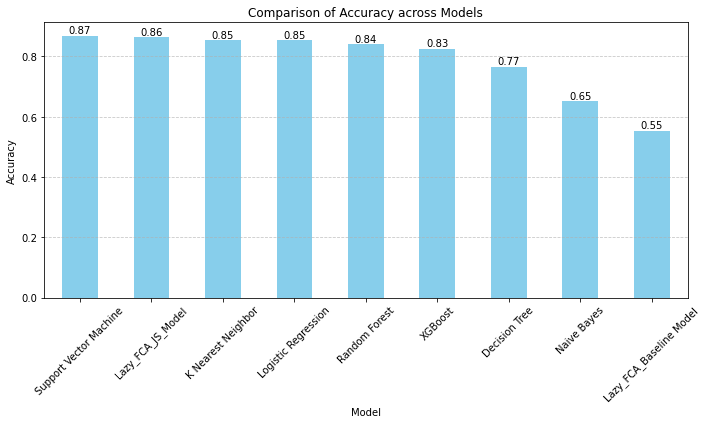

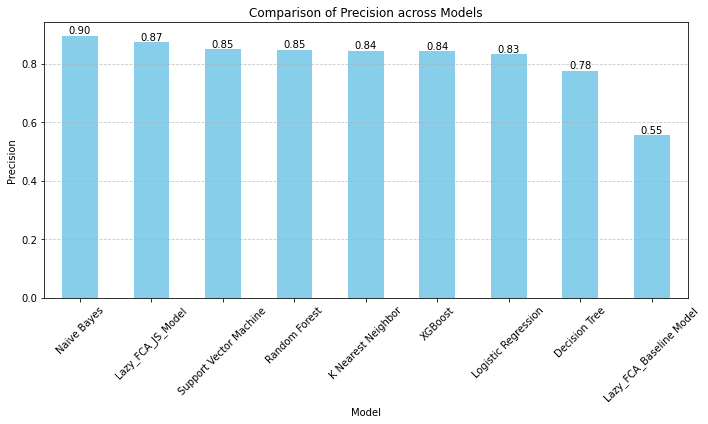

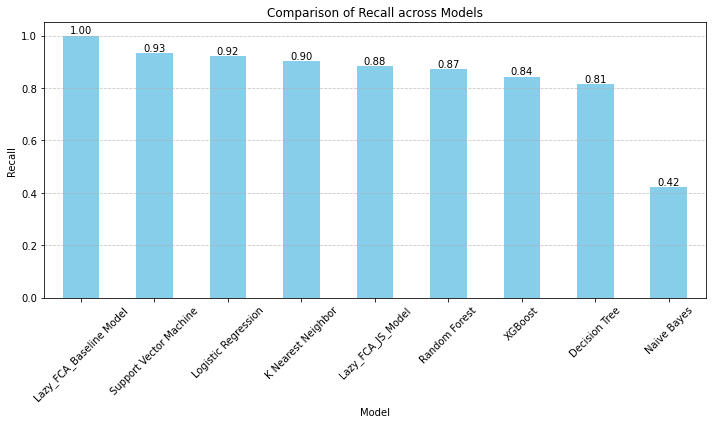

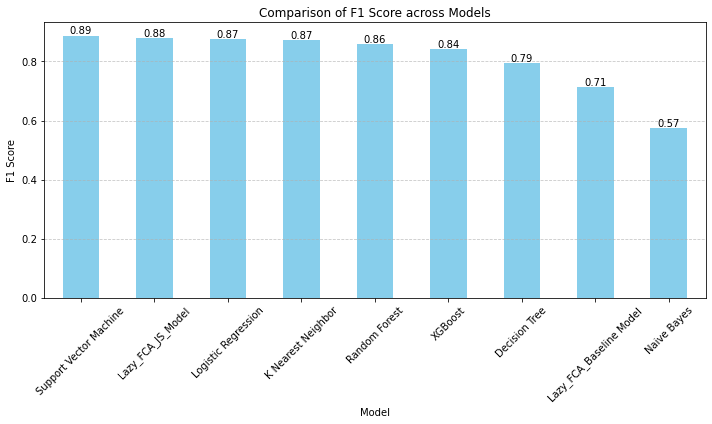

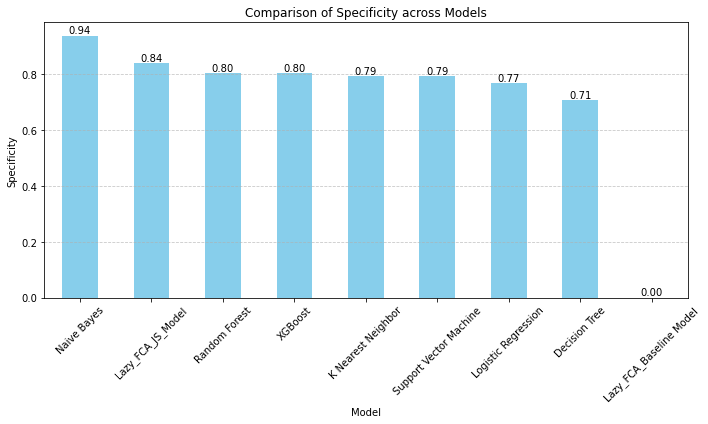

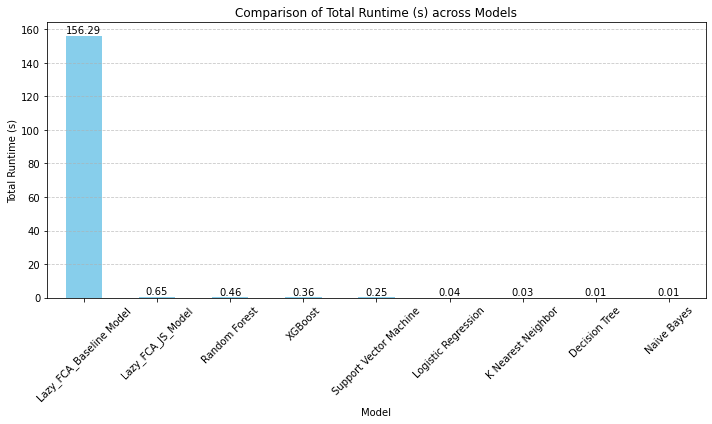

In [51]:
# Step 6: Visualize metrics
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score", "Specificity", "Total Runtime (s)"]

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    # Sort and plot the metric
    sorted_metrics = metrics_df[metric].sort_values(ascending=False)
    ax = sorted_metrics.plot(kind="bar", color="skyblue")
    
    # Add values at the top of each bar
    for idx, value in enumerate(sorted_metrics):
        plt.text(idx, value, f"{value:.2f}", ha="center", va="bottom", fontsize=10)

    # Add titles and labels
    plt.title(f"Comparison of {metric} across Models")
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()